# Case Study: Product Data Sales Trend

## Importing libraries

In [38]:
import ast
from collections import Counter
from itertools import combinations
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from fuzzywuzzy import process
from hiclass import LocalClassifierPerParentNode, metrics
from joblib import dump, load
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch

plt.style.use(['ggplot'])
# Download the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rballe33/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
tax_df = pd.read_csv('ProductDataChallenge_02_ProductTaxonomy.csv')
print(tax_df.shape)
print(tax_df.dtypes)
tax_df.head()

(727421, 2)
item_name                   object
original_format_category    object
dtype: object


,item_name,original_format_category
0,Women's Tune Squad Graphic Lounge Shorts - Yel...,Apparel & Accessories > Clothing > Shorts
1,Nickelodeon Cra-Z-Sand Tri-Color Bucket of Sand,Toys & Games > Toys > Art & Drawing Toys > Pla...
2,Apollo Tools 53pc DT9773 Household Tool Kit wi...,Hardware > Tools > Tool Sets > Hand Tool Sets
3,Henckels Forged Classic Christopher Kimball 3p...,Home & Garden > Kitchen & Dining > Kitchen Too...
4,BOBS from Skechers Blue Printed Dog Walking Ki...,Animals & Pet Supplies > Pet Supplies > Dog Su...


In [5]:
tax_df["original_format_category"].value_counts().to_frame()

,original_format_category
Apparel & Accessories > Shoes,67356
Apparel & Accessories > Clothing > Shirts & Tops,60853
Apparel & Accessories > Clothing > Pants,25185
Clothing > Tops > Tops & Tees,19503
Media > Books,14284
...,...
Halloween Costumes > Costume Accessories > Costume Jewelry,1
Tool Accessories > Power Tool Accessories > Saw Accessories > Circular Saw Accessories,1
"Garden Plants,Garden Plants > Christmas Store > Last Minute Christmas Trees and Gifts,Default Category,Garden Plants > Christmas Store > Indoor Plants,Garden Plants > Christmas Store > Christmas Plants and Living Gifts,Garden Plants > House & Office Plan",1
"Default Category,Garden Plants > Special Deals,Garden Plants > Palms & Palm Trees for Patio and Garden,Garden Plants,Garden Plants > Patio Plants",1


In [6]:
sales_df = pd.read_csv('ProductDataChallenge_01_ProductSales_thanksgiving_week.csv')
print(sales_df.shape)
print(sales_df.dtypes)
sales_df.head()

(1133897, 7)
action_id       object
sqldate         object
item_name       object
country         object
payout_type     object
saleamt        float64
commission     float64
dtype: object


,action_id,sqldate,item_name,country,payout_type,saleamt,commission
0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.0,11.05
1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.5,1.47
2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.0,0.00
3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06
4,4270.5081.1564705,2021-11-29,adidas Adissage Slides Core Black M 12 / W 13 ...,US,PCT_OF_SALEAMOUNT,21.0,2.52


In [7]:
combined_df = pd.merge(sales_df, tax_df, on='item_name', how='left')
combined_df

,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category
0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.000000,11.050000,NaN
1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.500000,1.470000,NaN
2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.000000,0.000000,NaN
3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.400000,1.060000,Apparel > Loose > Bottoms > Jeans
4,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.400000,1.060000,Apparel > Exclusion FIFTEEN > Bottoms > Jeans
...,...,...,...,...,...,...,...,...
1245349,9581.5081.2128315,2021-11-29,Vincero The Chrono S - Gunmetal/Walnut,US,PCT_OF_SALEAMOUNT,131.250000,5.250000,Apparel & Accessories > Jewelry > Watches
1245350,10151.5081.168180,2021-11-29,Gap Toddler Girls' 100% Organic Cotton Mix And...,GB,PCT_OF_SALEAMOUNT,5.361045,0.640125,NaN
1245351,10151.5081.94022,2021-11-29,Gap Men's Classic Long Sleeve T-Shirt Billie J...,GB,PCT_OF_SALEAMOUNT,11.962331,1.440281,NaN
1245352,9941.5074.144338,2021-11-22,Full Spectrum Favorites – 30mg Full Spectrum C...,US,PCT_OF_SALEAMOUNT,100.000000,52.000000,NaN


## Exploratory data analysis

In [8]:
# count nans

combined_df['original_format_category'].isnull().sum() / len(combined_df)

# 68% are nans

0.6830057959423586

In [9]:
tax_df.loc[(tax_df['item_name'] == 'Loose Built-In Flex Jeans For Men')]

,item_name,original_format_category
84757,Loose Built-In Flex Jeans For Men,Apparel > Loose > Bottoms > Jeans
117323,Loose Built-In Flex Jeans For Men,Apparel > Exclusion FIFTEEN > Bottoms > Jeans


In [10]:
# there seem to be multiple original_format_category's per item_name in taxonomy

sorted_df = tax_df.loc[(~tax_df['original_format_category'].isnull())].groupby("item_name")["original_format_category"].count().reset_index(name='Count').sort_values(by='Count', ascending=False)
sorted_df = sorted_df.loc[(sorted_df['Count'] > 1)]
sorted_df

,item_name,Count
396221,Mesh Unlined Underwire Plunge Bra for Women,15
266262,High-Waisted Pixie Straight-Leg Ankle Pants fo...,13
266035,High-Waisted Cropped Leggings For Women,13
266075,High-Waisted Flare Leggings for Women,12
266058,High-Waisted Double-Knot Ankle Leggings For Women,12
...,...,...
409797,Multi-Color Seed-Bead Drop Earrings for Women,2
363487,Maternity Striped Seersucker Halter One-Piece ...,2
531497,Sonoma Goods For Life® Custom Cordless Light F...,2
531501,Sonoma Goods For Life® Custom Cordless Light F...,2


In [11]:
# subsetting the taxonomy data to get the items that have multiple categories
subset_tax_df = tax_df[tax_df['item_name'].isin(sorted_df['item_name'])]
subset_tax_df

,item_name,original_format_category
1,Nickelodeon Cra-Z-Sand Tri-Color Bucket of Sand,Toys & Games > Toys > Art & Drawing Toys > Pla...
4,BOBS from Skechers Blue Printed Dog Walking Ki...,Animals & Pet Supplies > Pet Supplies > Dog Su...
24,Ankle Socks 12-Pack For Women,Accessories > Crazy TWELVE > Socks or Tights >...
45,Women's Sleeveless Tiered Gauze Dress - Univer...,Apparel & Accessories > Clothing > One-Pieces ...
116,Maternity Rollover-Waist OGC Chino Pants,Apparel > Crazy THIRTEEN > Bottoms > Pants
...,...,...
727201,1st Birthday Baseball Cap,Arts & Entertainment > Party & Celebration > P...
727310,6 1/2 x 9 Medium Kraft Paper Gift Bags - 12 Pc.,Arts & Entertainment > Party & Celebration > G...
727336,Women's Super-High Rise Cut-Off Jean Shorts - ...,Apparel & Accessories > Clothing > Activewear ...
727384,Pandora Moments Multi Snake Chain Bracelet,Apparel & Accessories > Jewelry


In [12]:
subset_tax_df.loc[(subset_tax_df['item_name'] == 'Teen V-Neck Top')]

,item_name,original_format_category


In [13]:
# take subset of combined_df that has no nulls and where there are multiple categories per item_name
# we can then apply fuzzy matching to select the category per item that matches most closely from a text perspective

In [14]:
# Function to clean and preprocess item names using fuzzy matching
def clean_item_name(item_name):
    cleaned_name = ' '.join(item_name.split()).lower()
    return cleaned_name

# Apply the cleaning function to the 'Item_Name' column
subset_tax_df['cleaned_item_name'] = subset_tax_df['item_name'].apply(clean_item_name)

# Ensure all values in 'original_format_category' are strings
subset_tax_df['original_format_category'] = subset_tax_df['original_format_category'].astype(str)

# Function to resolve categories based on fuzzy matching
def resolve_category(categories):
    item_name = categories.iloc[0, 0]
    categories = categories.iloc[:, 1].tolist()
    
    # Calculate fuzzy match scores for each category
    match_scores = [(category, process.extractOne(item_name, [category])[1]) for category in categories]

    # Choose the category with the highest fuzzy match score
    chosen_category, _ = max(match_scores, key=lambda x: x[1])
    return chosen_category

# Group by 'cleaned_item_name' and resolve categories
resolved_categories = subset_tax_df.groupby('item_name').apply(resolve_category).reset_index()
resolved_categories.columns = ['item_name', 'resolved_category']

resolved_categories.head()

/tmp/ipykernel_4233/3524503912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_tax_df['cleaned_item_name'] = subset_tax_df['item_name'].apply(clean_item_name)
/tmp/ipykernel_4233/3524503912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_tax_df['original_format_category'] = subset_tax_df['original_format_category'].astype(str)


,item_name,resolved_category
0,Paeonia Coral Sunset - Pe...,"Garden Plants > Plant Type > Peony Plants,Defa..."
1,Pennisetum × advena 'Rubru...,"Default Category,Garden Plants > Ornamental Gr..."
2,Pair of Mini Standard WHITE Flo...,"Garden Plants > Roses > Standard Rose Trees,De..."
3,Lobelia speciosa Starship SCARLET - ...,Garden Plants > Perennials Plants & Herbaceous...
4,Geranium Rozanne - 'Jolly Bee' Hardy Gera...,"Garden Plants,Garden Plants > Perennials Plant..."


In [15]:
resolved_categories.loc[(resolved_categories['item_name'] == 'Loose Built-In Flex Jeans For Men')]

,item_name,resolved_category
5141,Loose Built-In Flex Jeans For Men,Apparel > Loose > Bottoms > Jeans


In [16]:
resolved_categories.loc[(resolved_categories['item_name'] == 'Teen V-Neck Top')]

,item_name,resolved_category


In [17]:
# join resolved category back onto combined_df to resolve
resolved_df = pd.merge(combined_df, resolved_categories, on='item_name', how='left')
resolved_df['final_resolved_category'] = resolved_df['resolved_category'].fillna(resolved_df['original_format_category'])
resolved_df

,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category
0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.000000,11.050000,NaN,NaN,NaN
1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.500000,1.470000,NaN,NaN,NaN
2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.000000,0.000000,NaN,NaN,NaN
3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.400000,1.060000,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans
4,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.400000,1.060000,Apparel > Exclusion FIFTEEN > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans
...,...,...,...,...,...,...,...,...,...,...
1245349,9581.5081.2128315,2021-11-29,Vincero The Chrono S - Gunmetal/Walnut,US,PCT_OF_SALEAMOUNT,131.250000,5.250000,Apparel & Accessories > Jewelry > Watches,NaN,Apparel & Accessories > Jewelry > Watches
1245350,10151.5081.168180,2021-11-29,Gap Toddler Girls' 100% Organic Cotton Mix And...,GB,PCT_OF_SALEAMOUNT,5.361045,0.640125,NaN,NaN,NaN
1245351,10151.5081.94022,2021-11-29,Gap Men's Classic Long Sleeve T-Shirt Billie J...,GB,PCT_OF_SALEAMOUNT,11.962331,1.440281,NaN,NaN,NaN
1245352,9941.5074.144338,2021-11-22,Full Spectrum Favorites – 30mg Full Spectrum C...,US,PCT_OF_SALEAMOUNT,100.000000,52.000000,NaN,NaN,NaN


In [18]:
# those with a final resolved category then become part of our training set
resolved_df['final_resolved_category'].isnull().sum() / len(resolved_df)
# we can only train on 1 - 0.683 = 31,7% of the data

0.6830057959423586

In [19]:
# this is the data that we can use for training
train_df = resolved_df.loc[(~resolved_df['final_resolved_category'].isnull())][['item_name','final_resolved_category']]
train_df

,item_name,final_resolved_category
3,Loose Built-In Flex Jeans For Men,Apparel > Loose > Bottoms > Jeans
4,Loose Built-In Flex Jeans For Men,Apparel > Loose > Bottoms > Jeans
6,Rugs USA Beige Yesteryear Fading Herati Medall...,Home & Garden > Decor > Rugs
8,Slouchy Cardigan Sweater for Women,Apparel & Accessories > Clothing > Shirts & Tops
10,Go-Dry Cool Printed Dolphin-Hem Run Shorts for...,Apparel & Accessories > Clothing > Activewear
...,...,...
1245344,Petite Wide-Leg Wool-Blend Pant,Apparel & Accessories > Clothing > Pants
1245346,clariti 1 day multifocal 90 Pack,Health & Beauty > Personal Care > Vision Care ...
1245347,Petite Mid-Rise Skinny Stretch-Corduroy Pant,Apparel & Accessories > Clothing > Pants
1245349,Vincero The Chrono S - Gunmetal/Walnut,Apparel & Accessories > Jewelry > Watches


In [20]:
# these is the data that requires categorization
predict_df = resolved_df.loc[(resolved_df['final_resolved_category'].isnull())][['item_name','final_resolved_category']]
predict_df

,item_name,final_resolved_category
0,adidas Supernova Shoes Cloud White 11 Womens,NaN
1,adidas Adilette Comfort Slides Core Black 10 Mens,NaN
2,Pro Tools | Ultimate Subscription ExpertPlus ...,NaN
5,adidas Adissage Slides Core Black M 12 / W 13 ...,NaN
7,adidas Classic Superlite No-Show Socks 6 Pairs...,NaN
...,...,...
1245345,Pandora Moments Bangle - Size 7.5 inches,NaN
1245348,Sparkling Wishbone Ring - Size 9 | Gold,NaN
1245350,Gap Toddler Girls' 100% Organic Cotton Mix And...,NaN
1245351,Gap Men's Classic Long Sleeve T-Shirt Billie J...,NaN


## Feature engineering

In [62]:
train_df['item_name'].tolist()[0:10]

['Loose BuiltIn Flex Jeans Men',
 'Loose BuiltIn Flex Jeans Men',
 'Rugs USA Beige Yesteryear Fading Herati Medallion rug Traditional Rectangle x',
 'Slouchy Cardigan Sweater Women',
 'GoDry Cool Printed DolphinHem Run Shorts Girls',
 'Cozy Gripper Sneaker Socks Women',
 'FauxLeather Work Boots Men',
 'Nike Air Force Low LV Indigo',
 'SilverToned Leaf Pendant Necklace Stud Earrings Set Women',
 'SilverToned Leaf Pendant Necklace Stud Earrings Set Women']

In [25]:
def preprocess_text(text):
    # remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize the text
    words = text.split()

    # temove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # rejoin the words into a clean sentence
    cleaned_text = ' '.join(words)

    return cleaned_text

In [26]:
train_df['item_name']

3                          Loose Built-In Flex Jeans For Men
4                          Loose Built-In Flex Jeans For Men
6          Rugs USA Beige Yesteryear Fading Herati Medall...
8                         Slouchy Cardigan Sweater for Women
10         Go-Dry Cool Printed Dolphin-Hem Run Shorts for...
                                 ...                        
1245344                      Petite Wide-Leg Wool-Blend Pant
1245346                     clariti 1 day multifocal 90 Pack
1245347         Petite Mid-Rise Skinny Stretch-Corduroy Pant
1245349               Vincero The Chrono S - Gunmetal/Walnut
1245353                                      Teen V-Neck Top
Name: item_name, Length: 394770, dtype: object

In [27]:
train_df['item_name'] = train_df['item_name'].apply(preprocess_text)
train_df['item_name']

3                               Loose BuiltIn Flex Jeans Men
4                               Loose BuiltIn Flex Jeans Men
6          Rugs USA Beige Yesteryear Fading Herati Medall...
8                             Slouchy Cardigan Sweater Women
10            GoDry Cool Printed DolphinHem Run Shorts Girls
                                 ...                        
1245344                        Petite WideLeg WoolBlend Pant
1245346                          clariti day multifocal Pack
1245347           Petite MidRise Skinny StretchCorduroy Pant
1245349                        Vincero Chrono GunmetalWalnut
1245353                                       Teen VNeck Top
Name: item_name, Length: 394770, dtype: object

In [42]:
train_df['item_name'].tolist()[0:10]

['Loose BuiltIn Flex Jeans Men',
 'Loose BuiltIn Flex Jeans Men',
 'Rugs USA Beige Yesteryear Fading Herati Medallion rug Traditional Rectangle x',
 'Slouchy Cardigan Sweater Women',
 'GoDry Cool Printed DolphinHem Run Shorts Girls',
 'Cozy Gripper Sneaker Socks Women',
 'FauxLeather Work Boots Men',
 'Nike Air Force Low LV Indigo',
 'SilverToned Leaf Pendant Necklace Stud Earrings Set Women',
 'SilverToned Leaf Pendant Necklace Stud Earrings Set Women']

In [29]:
train_df['final_resolved_category'].tolist()[0:10]

['Apparel > Loose > Bottoms > Jeans',
 'Apparel > Loose > Bottoms > Jeans',
 'Home & Garden > Decor > Rugs',
 'Apparel & Accessories > Clothing > Shirts & Tops',
 'Apparel & Accessories > Clothing > Activewear',
 'Apparel & Accessories > Clothing > Underwear & Socks > Socks',
 'Accessories > Exclusion ELEVEN > Accessories > Boots',
 'Apparel & Accessories > Shoes',
 'Accessories > 3rd Party > Jewelry > Jewelry',
 'Accessories > 3rd Party > Jewelry > Jewelry']

In [32]:
train_df['final_resolved_category']

3                          Apparel > Loose > Bottoms > Jeans
4                          Apparel > Loose > Bottoms > Jeans
6                               Home & Garden > Decor > Rugs
8           Apparel & Accessories > Clothing > Shirts & Tops
10             Apparel & Accessories > Clothing > Activewear
                                 ...                        
1245344             Apparel & Accessories > Clothing > Pants
1245346    Health & Beauty > Personal Care > Vision Care ...
1245347             Apparel & Accessories > Clothing > Pants
1245349            Apparel & Accessories > Jewelry > Watches
1245353     Apparel & Accessories > Clothing > Shirts & Tops
Name: final_resolved_category, Length: 394770, dtype: object

In [34]:
train_df['final_resolved_category'].tolist()[0:10]

['Apparel > Loose > Bottoms > Jeans',
 'Apparel > Loose > Bottoms > Jeans',
 'Home & Garden > Decor > Rugs',
 'Apparel & Accessories > Clothing > Shirts & Tops',
 'Apparel & Accessories > Clothing > Activewear',
 'Apparel & Accessories > Clothing > Underwear & Socks > Socks',
 'Accessories > Exclusion ELEVEN > Accessories > Boots',
 'Apparel & Accessories > Shoes',
 'Accessories > 3rd Party > Jewelry > Jewelry',
 'Accessories > 3rd Party > Jewelry > Jewelry']

In [35]:
def split_text_into_words(text):
    return [word.strip() for word in text.split(">")]

train_df['final_resolved_category'] = train_df['final_resolved_category'].apply(split_text_into_words)
train_df['final_resolved_category'].tolist()[0:10]

[['Apparel', 'Loose', 'Bottoms', 'Jeans'],
 ['Apparel', 'Loose', 'Bottoms', 'Jeans'],
 ['Home & Garden', 'Decor', 'Rugs'],
 ['Apparel & Accessories', 'Clothing', 'Shirts & Tops'],
 ['Apparel & Accessories', 'Clothing', 'Activewear'],
 ['Apparel & Accessories', 'Clothing', 'Underwear & Socks', 'Socks'],
 ['Accessories', 'Exclusion ELEVEN', 'Accessories', 'Boots'],
 ['Apparel & Accessories', 'Shoes'],
 ['Accessories', '3rd Party', 'Jewelry', 'Jewelry'],
 ['Accessories', '3rd Party', 'Jewelry', 'Jewelry']]

In [63]:
y = train_df['final_resolved_category']
y.head()

3                     [Apparel, Loose, Bottoms, Jeans]
4                     [Apparel, Loose, Bottoms, Jeans]
6                         [Home & Garden, Decor, Rugs]
8     [Apparel & Accessories, Clothing, Shirts & Tops]
10       [Apparel & Accessories, Clothing, Activewear]
Name: final_resolved_category, dtype: object

In [64]:
X = train_df['item_name']
X.head()

3                          Loose BuiltIn Flex Jeans Men
4                          Loose BuiltIn Flex Jeans Men
6     Rugs USA Beige Yesteryear Fading Herati Medall...
8                        Slouchy Cardigan Sweater Women
10       GoDry Cool Printed DolphinHem Run Shorts Girls
Name: item_name, dtype: object

In [65]:
#X = [' '.join(category) for category in X]
vectorizer = CountVectorizer(max_features=200, min_df=10)
X = vectorizer.fit_transform(X)

In [66]:
print(X.toarray()[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [67]:
transformer = TfidfTransformer()
X = transformer.fit_transform(X)

In [ ]:
print(X.toarray()[0])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
X_train[0:1].toarray()

In [70]:
X_test[0:10]

<10x200 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [71]:
y_train[0:10]

1236309              [Apparel, Vintage Slim, Bottoms, Jeans]
602965     [Apparel & Accessories, Clothing, Sleepwear & ...
608599              [Accessories, Multi-Packs, Socks, Socks]
1013825     [Apparel & Accessories, Clothing, Shirts & Tops]
877812                     [Apparel & Accessories, Clothing]
695437          [Apparel, Back to School, Bottoms, Leggings]
845978     [Apparel & Accessories, Jewelry, Charms & Pend...
384398     [Apparel & Accessories, Clothing, Sleepwear & ...
1233386    [Apparel & Accessories, Clothing, Sleepwear & ...
277831     [Apparel & Accessories, Clothing, Shirts & Top...
Name: final_resolved_category, dtype: object

In [72]:
y_test[0:10]

739113    [Vehicles & Parts, Vehicle Parts & Accessories...
772808    [Apparel & Accessories, Clothing Accessories, ...
945395    [Apparel & Accessories, Jewelry, Charms & Pend...
298631             [Apparel & Accessories, Clothing, Pants]
531226                            [Apparel, Bottoms, Pants]
563238             [Apparel & Accessories, Clothing, Pants]
777446             [Apparel, Christmas, Bottoms, Sleepwear]
584753    [Accessories, Exclusion SIXTEEN, Socks or Tigh...
809658     [Apparel & Accessories, Clothing, Shirts & Tops]
703233                   [Apparel, Bootcut, Bottoms, Jeans]
Name: final_resolved_category, dtype: object

## Model training

In [45]:
print('pytorch version:', torch.__version__)
print('GPU:', torch.cuda.get_device_name(0))
print(torch.cuda.set_device(0))
print(torch.cuda.is_available())

pytorch version: 1.13.1+cu116
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
None
True


In [47]:
from hiclass import LocalClassifierPerNode, LocalClassifierPerParentNode
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from os import cpu_count
#from bert_sklearn import BertClassifier
from sklearn.linear_model import LogisticRegression

model = RandomForestClassifier()
#model = DecisionTreeClassifier()
#model = LogisticRegression(max_iter=1000)
#model = BertClassifier(max_seq_length=64, train_batch_size=16)
#classifier = LocalClassifierPerNode(local_classifier=model, n_jobs=cpu_count())
classifier = LocalClassifierPerNode(local_classifier=model, n_jobs=4)
#classifier = LocalClassifierPerParentNode(local_classifier=model, bert=True)
#classifier.fit(X_train.toarray(), y_train)
classifier.fit(X_train, y_train)

LocalClassifierPerNode(local_classifier=RandomForestClassifier(), n_jobs=4)

In [73]:
predictions = classifier.predict(X_test)

In [ ]:
predictions[0:10]

In [43]:
dump(classifier, 'classifier2.joblib')

['classifier2.joblib']

In [44]:
# predict categories for all items
all_items = resolved_df['item_name'].apply(preprocess_text)
all_items = vectorizer.fit_transform(all_items)
all_items = transformer.fit_transform(all_items)

In [54]:
all_predictions = classifier.predict(all_items[0:1000])

In [52]:
all_predictions

array([['Apparel & Accessories', 'Clothing', 'Pants', 'Jeans', '', '',
        ''],
       ['Apparel & Accessories', 'Clothing', 'Pants', 'Jeans', '', '',
        ''],
       ['Apparel & Accessories', 'Clothing Accessories',
        'Scarves & Shawls', 'Scarves', '', '', ''],
       ['Apparel', 'Breathe', 'Tops', 'Active Tops', '', '', ''],
       ['Apparel', 'Breathe', 'Tops', 'Active Tops', '', '', ''],
       ['Apparel & Accessories', 'Clothing', 'Pants', 'Jeans', '', '',
        ''],
       ['Home & Garden', 'Kitchen & Dining', 'Kitchen Appliances',
        'Vacuum Sealers', '', '', ''],
       ['Apparel & Accessories', 'Clothing', 'Dresses', '', '', '', ''],
       ['Health & Beauty', 'Personal Care', 'Cosmetics', 'Skin Care',
        'Lotion & Moisturizer', '', ''],
       ['Apparel & Accessories', 'Clothing', 'Pants', 'Jeans', '', '',
        '']], dtype='<U277')

In [45]:
classifier = load('classifier2.joblib')

## Model inference

In [47]:
# define the batch size
batch_size = 1000

# calculate the total number of batches
num_batches = len(resolved_df['item_name']) // batch_size + 1

# initialize an empty list to store the predictions
all_predictions = []

# process the data in batches
for i in range(num_batches):
    # determine the start and end indices for the current batch
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    
    # extract the current batch of data
    batch_data = all_items[start_idx:end_idx]
    
    # make predictions on the current batch
    batch_predictions = classifier.predict(batch_data)
    
    # append the batch predictions to the list of all predictions
    all_predictions.extend(batch_predictions)
    print("batch: ", str(start_idx) + ":" + str(end_idx))

# convert the list of predictions to a numpy array if needed
all_predictions = np.array(all_predictions)


batch:  0:1000
batch:  1000:2000
batch:  2000:3000
batch:  3000:4000
batch:  4000:5000
batch:  5000:6000
batch:  6000:7000
batch:  7000:8000
batch:  8000:9000
batch:  9000:10000
batch:  10000:11000
batch:  11000:12000
batch:  12000:13000
batch:  13000:14000
batch:  14000:15000
batch:  15000:16000
batch:  16000:17000
batch:  17000:18000
batch:  18000:19000
batch:  19000:20000
batch:  20000:21000
batch:  21000:22000
batch:  22000:23000
batch:  23000:24000
batch:  24000:25000
batch:  25000:26000
batch:  26000:27000
batch:  27000:28000
batch:  28000:29000
batch:  29000:30000
batch:  30000:31000
batch:  31000:32000
batch:  32000:33000
batch:  33000:34000
batch:  34000:35000
batch:  35000:36000
batch:  36000:37000
batch:  37000:38000
batch:  38000:39000
batch:  39000:40000
batch:  40000:41000
batch:  41000:42000
batch:  42000:43000
batch:  43000:44000
batch:  44000:45000
batch:  45000:46000
batch:  46000:47000
batch:  47000:48000
batch:  48000:49000
batch:  49000:50000
batch:  50000:51000
ba

In [48]:
resolved_df['predicted_category'] = [','.join(row) for row in all_predictions]
resolved_df.head()

,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category
0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.0,11.05,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,"
1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.5,1.47,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,"
2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.0,0.00,NaN,NaN,NaN,"Apparel & Accessories,Clothing Accessories,Sca..."
3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,"
4,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Exclusion FIFTEEN > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,"


In [49]:
resolved_df.to_csv('resolved_df2.csv')

In [74]:
metrics.f1(y_test, predictions)

0.8574600387459096

In [75]:
metrics.precision(y_test, predictions)

0.7941321739247302

In [76]:
metrics.recall(y_test, predictions)

0.9317632588375825

## Analysis for product questions

In [4]:
resolved_df = pd.read_csv("resolved_df2.csv")
resolved_df.head()

,Unnamed: 0,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category
0,0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.0,11.05,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,"
1,1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.5,1.47,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,"
2,2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.0,0.00,NaN,NaN,NaN,"Apparel & Accessories,Clothing Accessories,Sca..."
3,3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,"
4,4,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Exclusion FIFTEEN > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,"


In [5]:
resolved_df['formatted_predicted_category'] = resolved_df['predicted_category'].str.replace(',', ' > ').str.strip()
resolved_df.head()

,Unnamed: 0,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category,formatted_predicted_category
0,0,4270.5079.279362,2021-11-27,adidas Supernova Shoes Cloud White 11 Womens,US,PCT_OF_SALEAMOUNT,65.0,11.05,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,",Apparel & Accessories > Clothing > Pants > Jea...
1,1,4270.5080.265784,2021-11-28,adidas Adilette Comfort Slides Core Black 10 Mens,US,PCT_OF_SALEAMOUNT,24.5,1.47,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Pants,Jeans,,,",Apparel & Accessories > Clothing > Pants > Jea...
2,2,9800.5081.66990,2021-11-29,Pro Tools | Ultimate Subscription ExpertPlus ...,FR,PCT_OF_SALEAMOUNT,0.0,0.00,NaN,NaN,NaN,"Apparel & Accessories,Clothing Accessories,Sca...",Apparel & Accessories > Clothing Accessories >...
3,3,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,",Apparel > Breathe > Tops > Active Tops > > >
4,4,10310.5077.1677940,2021-11-26,Loose Built-In Flex Jeans For Men,CA,PCT_OF_SALEAMOUNT,35.4,1.06,Apparel > Exclusion FIFTEEN > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,Apparel > Loose > Bottoms > Jeans,"Apparel,Breathe,Tops,Active Tops,,,",Apparel > Breathe > Tops > Active Tops > > >


In [8]:
############################
# checking the dates
############################
# thanksgiving was Thursday 25 November in 2021
# technically, should the week stem from Mon 22nd until Sunday 28th (7 days)?
# black friday was Friday 26 November 2021
# cyber monday was Monday 29 November 2021
resolved_df.groupby('sqldate')['sqldate'].count()

sqldate
2021-11-22     90098
2021-11-23     78126
2021-11-24     97706
2021-11-25    153550
2021-11-26    292890
2021-11-27    144991
2021-11-28    155067
2021-11-29    232926
Name: sqldate, dtype: int64

In [9]:
# mainly US and CA centric
# one option for this exercise would be perform the analysis per country
# what about the non-English text? different classification model per country? 
resolved_df.groupby('country')['country'].count().sort_values(ascending=False)

country
US    740166
CA    360337
GB     69856
AU     26057
SG      9302
       ...  
SO         1
SM         1
MG         1
PG         1
GL         1
Name: country, Length: 176, dtype: int64

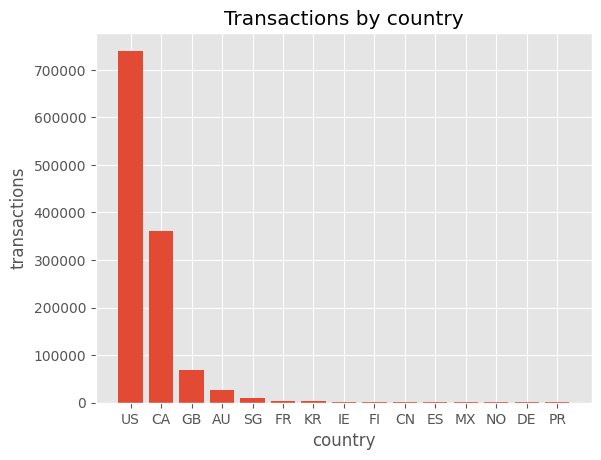

In [52]:
result = resolved_df.groupby('country').size().reset_index(name='count')
result = result.sort_values(by='count', ascending=False).head(15)

plt.bar(result['country'], result['count'])
plt.xlabel('country')
plt.ylabel('transactions')
plt.title('Transactions by country')
plt.show()

In [25]:
# big jump in sales for CA relative to US on 25th and 26th
resolved_df.loc[(resolved_df['country'].isin(['US','CA','GB']))].groupby(['sqldate','country'])['sqldate'].count()

sqldate     country
2021-11-22  CA          19747
            GB          11502
            US          52081
2021-11-23  CA          19309
            GB           7922
            US          45144
2021-11-24  CA          20524
            GB           7342
            US          61856
2021-11-25  CA          62027
            GB           8147
            US          73851
2021-11-26  CA         100047
            GB          14957
            US         162248
2021-11-27  CA          40912
            GB           4819
            US          90606
2021-11-28  CA          40332
            GB           5129
            US          99011
2021-11-29  CA          57439
            GB          10038
            US         155369
Name: sqldate, dtype: int64

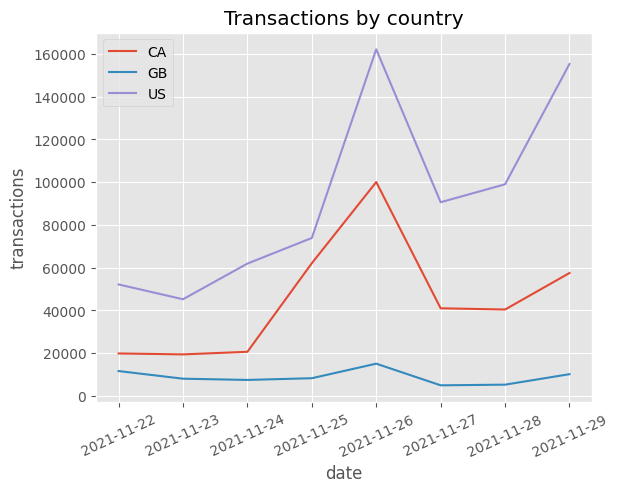

In [65]:
# Assuming 'resolved_df' is your DataFrame
filtered_df = resolved_df.loc[resolved_df['country'].isin(['US', 'CA', 'GB'])]

grouped_df = filtered_df.groupby(['sqldate', 'country']).size().unstack(fill_value=0).reset_index()
grouped_df.columns.name = None  # To remove the column name from the result

plt.plot(grouped_df['sqldate'], grouped_df['CA'], label='CA')
plt.plot(grouped_df['sqldate'], grouped_df['GB'], label='GB')
plt.plot(grouped_df['sqldate'], grouped_df['US'], label='US')
plt.legend(loc='upper left')
plt.title('Transactions by country')
plt.xlabel('date')
plt.ylabel('transactions')
plt.xticks(rotation=25)
plt.show()

In [10]:
# vast majority are PCT_OF_SALEAMOUNT
resolved_df.groupby('payout_type')['payout_type'].count()

payout_type
FIXED_AMOUNT           62192
PCT_OF_SALEAMOUNT    1183162
Name: payout_type, dtype: int64

In [26]:
resolved_df.groupby(['sqldate','payout_type'])['sqldate'].count()

sqldate     payout_type      
2021-11-22  FIXED_AMOUNT           5966
            PCT_OF_SALEAMOUNT     84132
2021-11-23  FIXED_AMOUNT           4738
            PCT_OF_SALEAMOUNT     73388
2021-11-24  FIXED_AMOUNT           5353
            PCT_OF_SALEAMOUNT     92353
2021-11-25  FIXED_AMOUNT           4369
            PCT_OF_SALEAMOUNT    149181
2021-11-26  FIXED_AMOUNT          13844
            PCT_OF_SALEAMOUNT    279046
2021-11-27  FIXED_AMOUNT           7855
            PCT_OF_SALEAMOUNT    137136
2021-11-28  FIXED_AMOUNT           8264
            PCT_OF_SALEAMOUNT    146803
2021-11-29  FIXED_AMOUNT          11803
            PCT_OF_SALEAMOUNT    221123
Name: sqldate, dtype: int64

In [11]:
# why so many $0 sales?
resolved_df.groupby('saleamt')['saleamt'].count()

saleamt
0.000000        10166
0.007123            4
0.007124            2
0.007142            2
0.010000            2
                ...  
50310.000000        1
50971.000000        1
51940.000000        1
55566.000000        1
57930.000000        1
Name: saleamt, Length: 61728, dtype: int64

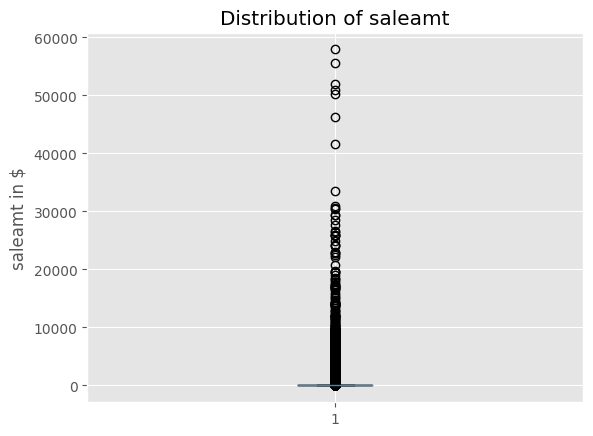

In [39]:
plt.boxplot(resolved_df['saleamt'])
plt.ylabel('saleamt in $')
plt.title('Distribution of saleamt')
plt.show()

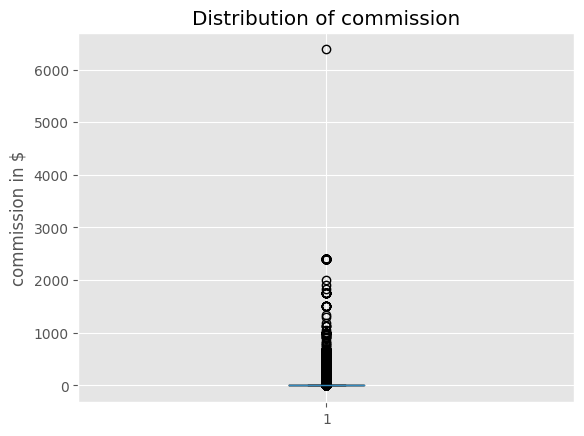

In [40]:
plt.boxplot(resolved_df['commission'])
plt.ylabel('commission in $')
plt.title('Distribution of commission')
plt.show()

In [41]:
resolved_df.loc[(resolved_df['commission'] > 6000)]

,Unnamed: 0,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category,formatted_predicted_category
1021947,1021947,3281.5081.1600560,2021-11-29,PageOne Lighting Skylight LED Round Flushmount...,US,PCT_OF_SALEAMOUNT,33580.8,6380.35,NaN,NaN,NaN,"Apparel & Accessories,Clothing,Shirts & Tops,T...",Apparel & Accessories > Clothing > Shirts & To...


In [12]:
# most have no commission, some have fixed/round amounts like 2400
# others seem like outliers i.e., 6380.35
resolved_df.groupby('commission')['commission'].count()

commission
0.000000       64166
0.007123          25
0.007124          34
0.007142          46
0.007156           3
               ...  
1839.240000        1
1910.320000        1
1994.100000        1
2400.000000       57
6380.350000        1
Name: commission, Length: 29008, dtype: int64

## 1. What product sales trends do you observe from the data during Thanksgiving holidays in 2021?

In [13]:
# average sale amount per day (individual items)
# lowest average sales amount per item on 25th
# highest on 23rd
resolved_df.groupby('sqldate')['saleamt'].mean()

sqldate
2021-11-22    77.794940
2021-11-23    83.396933
2021-11-24    73.453698
2021-11-25    56.165282
2021-11-26    63.844752
2021-11-27    66.095921
2021-11-28    72.077460
2021-11-29    73.570962
Name: saleamt, dtype: float64

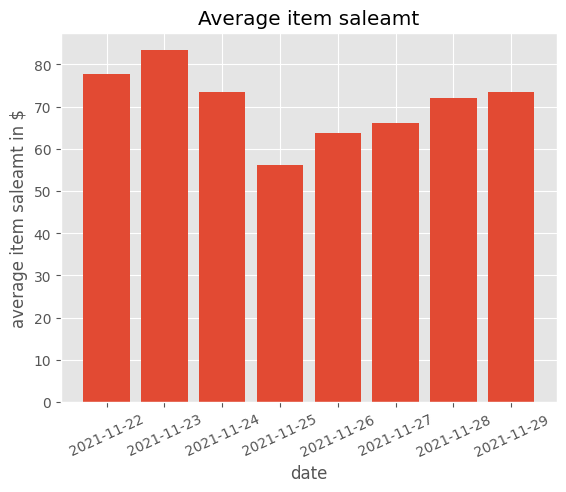

In [82]:
df_1 = resolved_df.groupby('sqldate')['saleamt'].mean().reset_index(name='mean_saleamt')

plt.bar(df_1['sqldate'], df_1['mean_saleamt'])
plt.xlabel('date')
plt.ylabel('average item saleamt in $')
plt.title('Average item saleamt')
plt.xticks(rotation=25)
plt.show()

In [83]:
# average sale amount per day (basket of items)
# highest basket values for 22nd and 23rd
# lowest basket valyes on 25th (thanksgiving)
resolved_df.groupby(['sqldate','action_id'])['saleamt'].mean().mean(level=0)

/tmp/ipykernel_12120/2867577565.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  resolved_df.groupby(['sqldate','action_id'])['saleamt'].mean().mean(level=0)


sqldate
2021-11-22    130.025899
2021-11-23    137.401384
2021-11-24    115.683548
2021-11-25    101.717894
2021-11-26    110.592887
2021-11-27    107.800733
2021-11-28    114.958431
2021-11-29    116.098008
Name: saleamt, dtype: float64

/tmp/ipykernel_12120/2321408254.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_bs = resolved_df.groupby(['sqldate','action_id'])['saleamt'].mean().mean(level=0).reset_index(name='average_basket_saleamt')


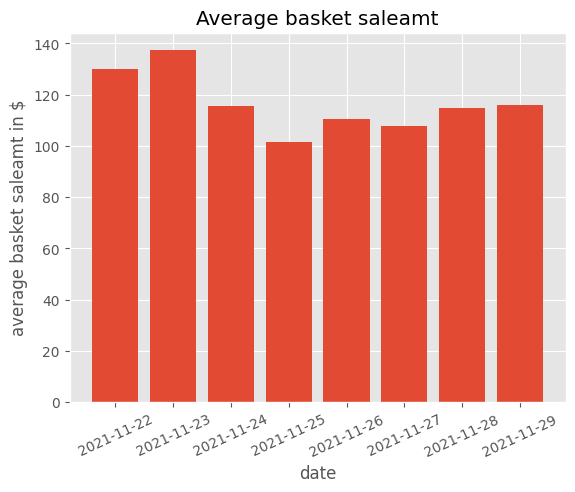

In [87]:
df_bs = resolved_df.groupby(['sqldate','action_id'])['saleamt'].mean().mean(level=0).reset_index(name='average_basket_saleamt')

plt.bar(df_bs['sqldate'], df_bs['average_basket_saleamt'])
plt.xlabel('date')
plt.ylabel('average basket saleamt in $')
plt.title('Average basket saleamt')
plt.xticks(rotation=25)
plt.show()

In [85]:
# average basket size by day
# thanksgiving (25th) had the highest average basket size of almost 3 items
# cyber monday had a lower average basket size of almost 2 items
resolved_df.groupby(['sqldate','action_id'])['item_name'].count().mean(level=0)

/tmp/ipykernel_12120/2133382321.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  resolved_df.groupby(['sqldate','action_id'])['item_name'].count().mean(level=0)


sqldate
2021-11-22    2.231143
2021-11-23    2.127846
2021-11-24    2.193866
2021-11-25    2.801138
2021-11-26    2.515718
2021-11-27    2.343175
2021-11-28    2.225288
2021-11-29    2.183531
Name: item_name, dtype: float64

/tmp/ipykernel_12120/194466245.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_2 = resolved_df.groupby(['sqldate','action_id'])['item_name'].size().mean(level=0).reset_index(name='basket_size')


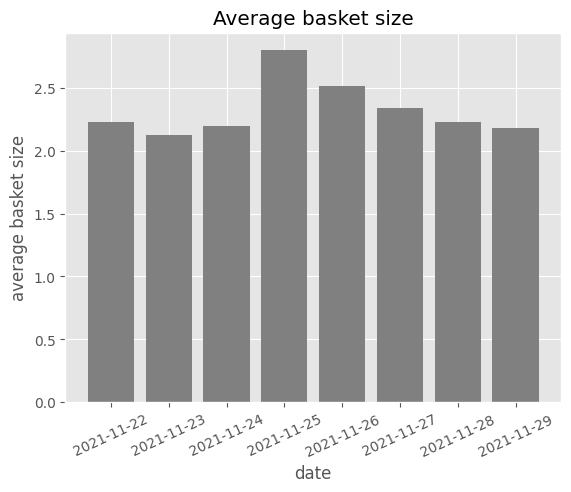

In [86]:
df_2 = resolved_df.groupby(['sqldate','action_id'])['item_name'].size().mean(level=0).reset_index(name='basket_size')

plt.bar(df_2['sqldate'], df_2['basket_size'], color='grey')
plt.xlabel('date')
plt.ylabel('average basket size')
plt.title('Average basket size')
plt.xticks(rotation=25)
plt.show()

## 2. What are the top selling products during Thanksgiving week 2021, overall and by product category? 

In [7]:
resolved_df.groupby('item_name')['item_name'].count().sort_values(ascending=False)

item_name
Oversized Vintage Tunic Sweatshirt for Women                3255
Printed Flannel Pajama Pants for Men                        3054
High-Waisted Jersey Ankle Leggings For Women                2794
Theragun Elite Black - Smart Percussive Therapy Massager    2697
Soft-Washed Crew-Neck T-Shirt for Men                       2580
                                                            ... 
Maria Cat-eye Black Glasses                                    1
Margot Cane Back Dining Side Chair in Cinder                   1
Margo Square Blue-Tortoise Glasses                             1
Margaret Muir Multi-coloured pixel cushion40 x 60 cm           1
Ｖ字衍縫斜背包                                                        1
Name: item_name, Length: 151920, dtype: int64

In [8]:
resolved_df.groupby('formatted_predicted_category')['formatted_predicted_category'].count().sort_values(ascending=False)

formatted_predicted_category
Apparel & Accessories > Clothing > Pants > Jeans >  >  >                                                         258451
Apparel & Accessories > Clothing > Shirts & Tops > T-Shirts >  >  >                                              169883
Vehicles & Parts > Vehicle Parts & Accessories > Motor Vehicle Parts > Motor Vehicle Suspension Parts >  >  >    152070
Apparel & Accessories > Shoes > Athletic Shoes & Sneakers > Sneakers >  >  >                                     113527
Apparel & Accessories > Jewelry > Charms & Pendants >  >  >  >                                                    87867
                                                                                                                  ...  
Apparel > Short Sleeve > Tops > Active Tops >  >  >                                                                   1
Apparel > Exclusion FIVE Exclusion EIGHTEEN > Bottoms > Jeans >  >  >                                                 1
Apparel > L

## 3. What are the highest commissioned product items?

In [11]:
resolved_df.groupby('item_name')['commission'].mean().sort_values(ascending=False)

item_name
PageOne Lighting Skylight LED Round Flushmount Light - Color: White - Size: 24" - PC111150-MH                                       6380.35
Mater High Stool - Premium Edition - Color: Black - Size: Counter - 01084                                                           1910.32
Serge Mouille Three Arm Multi-Light Pendant Light - Color: Black - Size: 3 light - CL/3RA                                           1329.05
Brando 74" Leather Sofa, Napoli Grey                                                                                                1294.56
1.7 Carat, Super Ideal Cut, D Color, VVS1 clarity Round Diamond                                                                     1179.00
                                                                                                                                     ...   
Arm & Hammer Training Pads for Stay-at-Home Dogs, Super Absorbent Leak-Proof Odor Control Quilted Pads with Baking Soda, 200 ct.       0.00
Arm & Hamm

In [27]:
resolved_df.groupby('item_name')['commission'].sum().sort_values(ascending=False)

item_name
The Business Platinum Card® from American Express                             187300.00
American Express Blue Business Cash™ Card                                     179215.00
Theragun Elite Black - Smart Percussive Therapy Massager                      112924.98
The Blue Business® Plus Credit Card from American Express                      49175.00
American Express® Business Gold Card                                           29050.00
                                                                                ...    
HyperX QuadCast Gaming USB Microphone - Black/Red                                  0.00
Zwilling J.A. Henckels Four Star Hollow-Edge Rocking Santoku                       0.00
HyperX CloudX Gaming Headset for Xbox Series X|S / Xbox One - Black/Silver         0.00
HyperX Cloud Stinger S Gaming Headset with Microphone - Black                      0.00
"0.23 RD Diamond (D, SI1)"                                                         0.00
Name: commission, Leng

In [29]:
# what does the card data represent?
resolved_df.loc[(resolved_df['item_name'] == 'The Business Platinum Card® from American Express')].head(10)

,Unnamed: 0,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category,formatted_predicted_category
844656,844656,7411.5075.618115,2021-11-23,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
846109,846109,7411.5078.3253045,2021-11-26,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,2400.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
846826,846826,7411.5075.644346,2021-11-23,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
848681,848681,7411.5077.2181014,2021-11-25,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
848736,848736,7411.5074.1615074,2021-11-22,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,1750.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
849338,849338,7411.5081.3395618,2021-11-29,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
849960,849960,7411.5079.241765,2021-11-27,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
849976,849976,7411.5079.89630,2021-11-27,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
850163,850163,7411.5077.2177049,2021-11-25,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,300.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...
851113,851113,7411.5074.271895,2021-11-22,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...


In [30]:
# let's isolate a single transaction to see if there are other items besides the card
resolved_df.loc[(resolved_df['action_id'] == '7411.5075.618115')].head(10)

,Unnamed: 0,action_id,sqldate,item_name,country,payout_type,saleamt,commission,original_format_category,resolved_category,final_resolved_category,predicted_category,formatted_predicted_category
844656,844656,7411.5075.618115,2021-11-23,The Business Platinum Card® from American Express,US,FIXED_AMOUNT,0.0,0.0,NaN,NaN,NaN,"Vehicles & Parts,Vehicle Parts & Accessories,M...",Vehicles & Parts > Vehicle Parts & Accessories...


In [31]:
# remove cards
resolved_df.loc[~resolved_df['item_name'].str.contains('card', case=False)].groupby('item_name')['commission'].sum().sort_values(ascending=False)

item_name
Theragun Elite Black - Smart Percussive Therapy Massager                  112924.98
Bowflex C6 Bike                                                            21745.17
Theragun Elite White - Smart Percussive Therapy Massager                   20165.46
Sony PS5 PlayStation 5 (US Plug) Blu-ray Edition Console 3005718 White     15162.46
Bowflex Max Trainer M6                                                     11626.86
                                                                            ...    
L&#233;ku&#233; 22-oz. Green Steamer Case with Tray + Free Cookbook            0.00
Kyocera&#174; Black Ceramic Paring Knife                                       0.00
Kyocera&#174; 2&#8211;Piece Asian Ceramic Knife Set                            0.00
Kyocera Ceramic Utility Knife                                                  0.00
"0.23 RD Diamond (D, SI1)"                                                     0.00
Name: commission, Length: 150771, dtype: float64

## 4. Which product items are frequently purchased together during Thanksgiving?  

In [29]:
# group by 'action_id' and create combinations of 'item_name' where items are not the same
grouped = resolved_df.groupby('action_id')['item_name'].apply(lambda x: list(combinations(x, 2)) if len(x) > 1 else [])

# sort items within each pair alphabetically
sorted_combinations = [tuple(sorted(pair)) for sublist in grouped for pair in sublist]

# count the frequency of each combination
combinations_count = Counter(sorted_combinations)

# filter out pairs where both elements are the same
filtered_combinations = [(pair, count) for pair, count in combinations_count.items() if pair[0] != pair[1]]

# find the most frequent combinations
most_frequent_combinations = sorted(filtered_combinations, key=lambda x: x[1], reverse=True)

In [31]:
most_frequent_combinations[0:10]

[(('High-Waisted Pixie Ankle Pants for Women',
   'High-Waisted Pixie Straight-Leg Ankle Pants for Women'),
  3432),
 (('Oversized Vintage Tunic Sweatshirt for Women',
   'Vintage Long-Sleeve Garment-Dyed French-Terry Tunic Sweatshirt for Women'),
  2856),
 (('High-Waisted Pixie Ankle Pants for Women',
   'High-Waisted Pixie Full-Length Pants for Women'),
  1680),
 (('High-Waisted Jersey Ankle Leggings For Women',
   'High-Waisted Rib-Knit Leggings For Women'),
  1540),
 (('Unisex Licensed Graphic Bodysuit for Baby',
   'Unisex Licensed Pop-Culture Graphic Bodysuit for Baby'),
  1296),
 (('High-Waisted Jersey Ankle Leggings For Women',
   'High-Waisted Printed Ankle Leggings For Women'),
  1155),
 (('High-Waisted Jersey Ankle Leggings For Women',
   'Mid-Rise Jersey-Knit Leggings For Women'),
  1155),
 (('High-Waisted 7/8-Length Leggings For Women',
   'High-Waisted Jersey Ankle Leggings For Women'),
  1100),
 (('Mid-Rise Dark-Wash Boot-Cut Jeans for Women',
   'Mid-Rise Medium-Wash Bo

## 5. Which product categories are most frequently purchased together during Thanksgiving?

In [32]:
# group by 'action_id' and create combinations of 'formatted_predicted_category' where categories are not the same
grouped = resolved_df.groupby('action_id')['formatted_predicted_category'].apply(lambda x: list(combinations(x, 2)) if len(x) > 1 else [])

# sort items within each pair alphabetically
sorted_combinations = [tuple(sorted(pair)) for sublist in grouped for pair in sublist]

# count the frequency of each combination
combinations_count = Counter(sorted_combinations)

# filter out pairs where both elements are the same
filtered_combinations = [(pair, count) for pair, count in combinations_count.items() if pair[0] != pair[1]]

# find the most frequent combinations
most_frequent_combinations = sorted(filtered_combinations, key=lambda x: x[1], reverse=True)

In [33]:
most_frequent_combinations[0:10]

[(('Apparel & Accessories > Clothing > Pants > Jeans >  >  >',
   'Apparel & Accessories > Clothing > Shirts & Tops > T-Shirts >  >  >'),
  196961),
 (('Apparel & Accessories > Clothing > Pants > Jeans >  >  >',
   'Apparel & Accessories > Shoes > Athletic Shoes & Sneakers > Sneakers >  >  >'),
  94346),
 (('Apparel & Accessories > Clothing > Shirts & Tops > T-Shirts >  >  >',
   'Apparel & Accessories > Shoes > Athletic Shoes & Sneakers > Sneakers >  >  >'),
  81766),
 (('Apparel & Accessories > Clothing > Pants > Jeans >  >  >',
   'Apparel & Accessories > Jewelry > Charms & Pendants >  >  >  >'),
  71005),
 (('Apparel & Accessories > Clothing > Shirts & Tops > Polo Shirts >  >  >',
   'Apparel & Accessories > Clothing > Shirts & Tops > T-Shirts >  >  >'),
  51466),
 (('Apparel & Accessories > Clothing > Shirts & Tops > T-Shirts >  >  >',
   'Apparel & Accessories > Jewelry > Charms & Pendants >  >  >  >'),
  48396),
 (('Apparel & Accessories > Clothing > Pants > Jeans >  >  >',
   '

## 6. How were product sales trends similar or different between Black Friday and Cyber Monday? 

In [47]:
resolved_df.loc[(resolved_df['sqldate'] == '2021-11-26')].groupby('item_name')['item_name'].count().sort_values(ascending=False)[0:10]

item_name
Printed Flannel Pajama Pants for Men                        1450
Oversized Vintage Tunic Sweatshirt for Women                 966
High-Waisted Jersey Ankle Leggings For Women                 836
Cozy Crew Socks For Women                                    798
Theragun Elite Black - Smart Percussive Therapy Massager     778
Soft-Washed Crew-Neck T-Shirt for Men                        680
High-Waisted Pixie Ankle Pants for Women                     576
Microfleece Pajama Jogger Pants for Boys                     556
Take a Break Coffee Cup Charm                                518
Printed Built-In Tough Full-Length Leggings for Girls        516
Name: item_name, dtype: int64

In [46]:
resolved_df.loc[(resolved_df['sqldate'] == '2021-11-26')].groupby('item_name')['saleamt'].sum().sort_values(ascending=False)[0:10]

item_name
Theragun Elite Black - Smart Percussive Therapy Massager                          316806.000000
Sony PS5 PlayStation 5 (US Plug) Blu-ray Edition Console 3005718 White            123663.000000
Dyson Special edition Dyson Supersonic™ hair dryer (Prussian blue/rich copper)    105101.088332
Bowflex C6 Bike                                                                    94648.020000
Jordan 4 Retro Lightning (2021)                                                    82207.230000
Pixel 6 De 128 Go De Google - Noir Orageux - Déverrouillé                          78370.623032
Jordan 5 Retro Moonlight (2021)                                                    61971.670000
"2.39 RD Diamond (I, VS1)"                                                         57930.000000
Theragun Elite White - Smart Percussive Therapy Massager                           53865.000000
Women's Lodge Cascadian Down Parka                                                 49250.720000
Name: saleamt, dtype: float64

In [48]:
resolved_df.loc[(resolved_df['sqldate'] == '2021-11-29')].groupby('item_name')['item_name'].count().sort_values(ascending=False)[0:10]

item_name
Theragun Elite Black - Smart Percussive Therapy Massager    682
Stowaway Packable 20L Daypack                               547
High-Waisted Light-Wash Straight-Leg Jeans for Women        456
Printed Built-In Tough Full-Length Leggings for Girls       420
Soft-Washed Crew-Neck T-Shirt for Men                       372
Men's CirrusLite Down Jacket                                372
Take a Break Coffee Cup Charm                               358
Sur La Table Electric Salt &#38; Pepper Mill Set            293
High-Waisted Jersey Ankle Leggings For Women                286
Jordan 4 Retro Shimmer (W)                                  283
Name: item_name, dtype: int64

In [49]:
resolved_df.loc[(resolved_df['sqldate'] == '2021-11-29')].groupby('item_name')['saleamt'].sum().sort_values(ascending=False)[0:10]

item_name
Theragun Elite Black - Smart Percussive Therapy Massager                  275709.000000
Sony PS5 PlayStation 5 (US Plug) Blu-ray Edition Console 3005718 White    161314.000000
Jordan 4 Retro Shimmer (W)                                                 84524.920000
Microsoft Xbox Series X (US Plug) RRT-00001 / RRT-00024 Black              83204.000000
Bowflex C6 Bike                                                            79693.240000
Sony PS5 PlayStation 5 (US Plug) Digital Edition Console 3005719 White     59650.410000
Bowflex Max Trainer M6                                                     57195.530000
Go Anywhere® Performance Un-Tucked Short Sleeve Shirt                      54415.699251
3.22 Carat, Super Ideal Cut, G Color, VS2 clarity Round Diamond            50310.000000
Jordan 1 Retro High Electro Orange                                         50291.000000
Name: saleamt, dtype: float64

## 7. What business recommendations can you provide based on the above analysis?  

**Top-Performing Products on Black Friday:**

1. **Theragun Elite Black - Smart Percussive Therapy Massager:** This product had the highest unit sales and revenue on Black Friday. It seems to be a popular choice among customers during the Black Friday sale.

2. **Printed Built-In Tough Full-Length Leggings for Girls:** While not the top revenue generator, this product had a significant number of unit sales, indicating a high demand for leggings during Black Friday.

3. **Soft-Washed Crew-Neck T-Shirt for Men:** This product had a good balance between unit sales and revenue, making it a valuable item for Black Friday sales.

**Top-Performing Products on Cyber Monday:**

1. **Theragun Elite Black - Smart Percussive Therapy Massager:** This product continued to perform well on Cyber Monday, indicating its sustained popularity.

2. **Stowaway Packable 20L Daypack:** This product had a high number of unit sales on Cyber Monday, suggesting that customers were interested in backpacks for holiday travel or gifting.

3. **High-Waisted Light-Wash Straight-Leg Jeans for Women:** Jeans for women were in demand on Cyber Monday, and this product performed strongly in terms of unit sales.

**Differences and Recommendations:**

1. **Product Continuity:** The "Theragun Elite Black - Smart Percussive Therapy Massager" consistently performed well on both Black Friday and Cyber Monday. Consider offering similar wellness or fitness products to capitalize on this trend.

2. **Seasonal Products:** The demand for specific products may vary based on the season. For example, leggings and T-shirts were popular on Black Friday, while backpacks and jeans gained traction on Cyber Monday. Tailor your inventory and promotions to align with seasonal preferences.

3. **Pricing Strategies:** Analyze the pricing strategies for products that performed exceptionally well. Are there discounts or special offers that attracted more customers? Adjust pricing strategies accordingly.

4. **Marketing and Promotion:** Review the marketing channels and campaigns used during both sales events. Identify which channels had the highest conversion rates and allocate resources accordingly in future sales events.

5. **Customer Insights:** Collect customer feedback and preferences to gain insights into their shopping behaviors. Use this information to curate product selections and enhance the overall shopping experience.

6. **Inventory Management:** Ensure that you have sufficient inventory of high-demand products, especially those that performed well on both occasions. Avoid stockouts to maximize sales potential.

7. **Cross-Selling and Bundling:** Consider cross-selling related products or creating bundles to increase the average order value. For example, offer discounts on leggings when purchasing T-shirts.

8. **Customer Retention:** Implement strategies to retain Black Friday and Cyber Monday customers throughout the year. Loyalty programs, personalized recommendations, and email marketing can help maintain engagement.

9. **Market Trends:** Stay updated on market trends and competitor offerings to remain competitive and adapt your product catalog accordingly.

10. **Data Analytics:** Continuously analyze sales data, customer behavior, and market trends to make data-driven decisions and fine-tune your sales strategies.